In [1]:
# uv init
# uv pip install ipykernel #for vscode
# %uv pip install numpy pandas matplotlib seaborn


In [2]:
# data seems to be organize in CSV files without extensions
# with the header line and columns of data. Classical pandas DataFrame format

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
def load_data(file_path):
    """
    Load data from a CSV file without an extension and format column names.
    
    Parameters:
    file_path (str): Path to the CSV file.
    
    Returns:
    pd.DataFrame: DataFrame containing the loaded data with formatted column names.
    """
    try:
        data = pd.read_csv(file_path, header=0)
        float_cols = data.select_dtypes(include='float').columns
        data[float_cols] = data[float_cols].round(3)
        # Remove leading/trailing spaces and replace internal spaces with underscores
        data.columns = [col.strip().replace(' ', '_') for col in data.columns]
        return data
    except Exception as e:
        print(f"Error loading data from {file_path}: {e}")
        return None

In [5]:
df = load_data('data/64X24X28 X=1 Z=1 bf=44p5 16')  # Replace 'data.csv' with your actual file path

In [6]:
df.columns

Index(['nodenumber', 'x-coordinate', 'y-coordinate', 'z-coordinate',
       'pressure', 'x-velocity', 'y-velocity', 'turb-kinetic-energy',
       'turb-diss-rate', 'viscosity-turb'],
      dtype='object')

(65,)

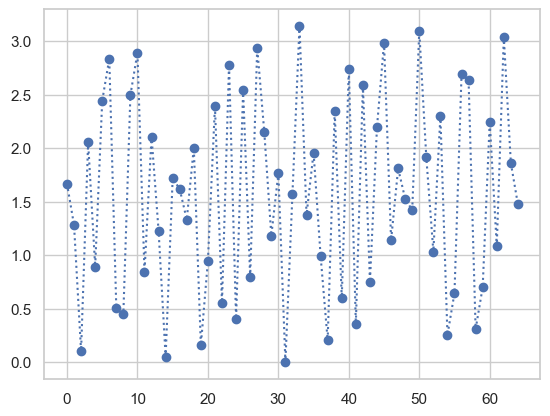

In [12]:
plt.plot(df['x-coordinate'].unique(),':o')
df['x-coordinate'].unique().shape

In [8]:
df['y-coordinate'].unique().shape

(661,)

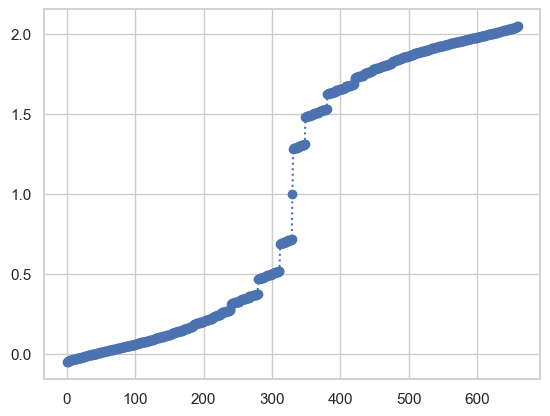

In [13]:
plt.plot(df['y-coordinate'].unique(),':o')

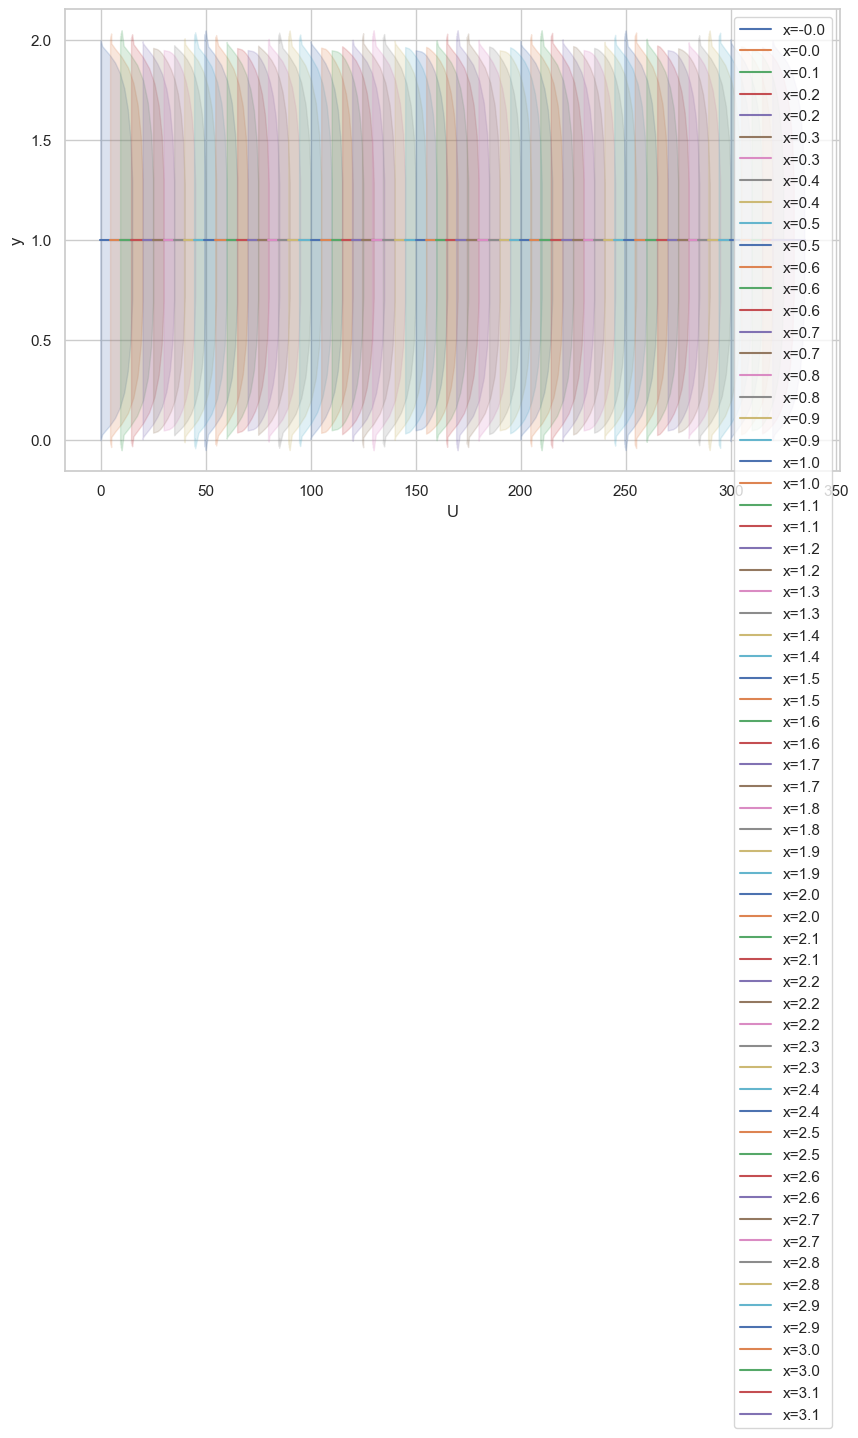

In [22]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))

df_plot = df.rename(columns={'y-coordinate': 'y', 'x-coordinate': 'x', 'x-velocity': 'U'})

for i, x_val in enumerate(sorted(df_plot['x'].unique())):
    subset = df_plot[df_plot['x'] == x_val].copy()
    offset = i * 5.0  # shift each line by 0.1 * index
    subset['U'] = subset['U'] + offset
    sns.lineplot(x='U', y='y', data=subset, label=f'x={x_val:.1f}')

plt.xlabel('U')
plt.ylabel('y')
# plt.legend(title='x-coordinate')
plt.show()
